# Tutorial 1: Active inference from scratch

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/infer-actively/pymdp/blob/master/docs/notebooks/active_inference_from_scratch.ipynb)

*Author: Conor Heins*

This tutorial guides you through the construction of an active inference agent "from scratch" in a simple grid-world environment. This tutorial is designed to walk you through the various mathematical operations required for running active inference in discrete state spaces, as well as introduce you to the way discrete probability distributions are represented in `pymdp` (through the use of numpy vectors and matrices). We also show you how to compute the expected free energy in terms of risk and ambiguity, and how to use it to plan sequences of actions.

By the end of this tutorial, you should be able to write simple active inference models from scratch using the main components of any POMDP generative model: the `A`, `B`, `C`, and `D` arrays, as well as be able to write the active inference loop for an agent engaged in a perception-action exchange with its environment.

*Note*: When running this notebook in Google Colab, you may have to run `!pip install inferactively-pymdp` at the top of the notebook, before you can `import pymdp`. That cell is left commented out below, in case you are running this notebook from Google Colab.

In [1]:
# ! pip install inferactively-pymdp

### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Define some auxiliary functions

Here are some plotting functions that will come in handy throughout the tutorial.

In [3]:
def plot_likelihood(matrix, xlabels = list(range(9)), ylabels = list(range(9)), title_str = "Likelihood distribution (A)"):
    """
    Plots a 2-D likelihood matrix as a heatmap
    """

    if not np.isclose(matrix.sum(axis=0), 1.0).all():
      raise ValueError("Distribution not column-normalized! Please normalize (ensure matrix.sum(axis=0) == 1.0 for all columns)")
    
    fig = plt.figure(figsize = (6,6))
    ax = sns.heatmap(matrix, xticklabels = xlabels, yticklabels = ylabels, cmap = 'gray', cbar = False, vmin = 0.0, vmax = 1.0)
    plt.title(title_str)
    plt.show()

def plot_grid(grid_locations, num_x = 3, num_y = 3 ):
    """
    Plots the spatial coordinates of GridWorld as a heatmap, with each (X, Y) coordinate 
    labeled with its linear index (its `state id`)
    """

    grid_heatmap = np.zeros((num_x, num_y))
    for linear_idx, location in enumerate(grid_locations):
      y, x = location
      grid_heatmap[y, x] = linear_idx
    sns.set(font_scale=1.5)
    sns.heatmap(grid_heatmap, annot=True, cbar = False, fmt='.0f', cmap='crest')

def plot_point_on_grid(state_vector, grid_locations):
    """
    Plots the current location of the agent on the grid world
    """
    state_index = np.where(state_vector)[0][0]
    y, x = grid_locations[state_index]
    grid_heatmap = np.zeros((3,3))
    grid_heatmap[y,x] = 1.0
    sns.heatmap(grid_heatmap, cbar = False, fmt='.0f')

def plot_beliefs(belief_dist, title_str=""):
    """
    Plot a categorical distribution or belief distribution, stored in the 1-D numpy vector `belief_dist`
    """

    if not np.isclose(belief_dist.sum(), 1.0):
      raise ValueError("Distribution not normalized! Please normalize")

    plt.grid(zorder=0)
    plt.bar(range(belief_dist.shape[0]), belief_dist, color='r', zorder=3)
    plt.xticks(range(belief_dist.shape[0]))
    plt.title(title_str)
    plt.show()


## **The Basics: categorical distributions**

Let's start by creating a simple categorical distribution $P(x)$. We will represent this distribution numerically with a 1-D `numpy` array (i.e. a `numpy.ndarray` where `ndim == 1`). The discrete entries of this vector can be thought of as the probabilities of seeing each of the $K$ alternative outcomes (the support of the distribution), if we were to sample once from the distribution. We can write the distribution as a vector of probabilities, follows:


$$
P(x) = \begin{bmatrix} P(x = 0) \\\ P(x = 1)\\\ \vdots \\\ P(x = K) \end{bmatrix}
$$ 

We can use `numpy` and the `norm_dist` function from `utils` library of `pymdp` to quickly create a random categorical distribution.


In [4]:
from pymdp import utils

In [5]:
my_categorical = np.random.rand(3)
# my_categorical = np.array([0.5, 0.3, 0.8]) # could also just write in your own numbers
my_categorical = utils.norm_dist(my_categorical) # normalizes the distribution so it integrates to 1.0

print(my_categorical.reshape(-1,1)) # we reshape it to display it like a column vector
print(f'Integral of the distribution: {round(my_categorical.sum(), 2)}')

[[0.73392685]
 [0.0057919 ]
 [0.26028125]]
Integral of the distribution: 1.0


 We can sample a discrete outcome from this distribution using the `sample()` function from the `utils` module

In [6]:
sampled_outcome = utils.sample(my_categorical)
print(f'Sampled outcome: {sampled_outcome}')

Sampled outcome: 0


Now plot the beliefs using our `plot_beliefs()` function that we defined in the beginning. 

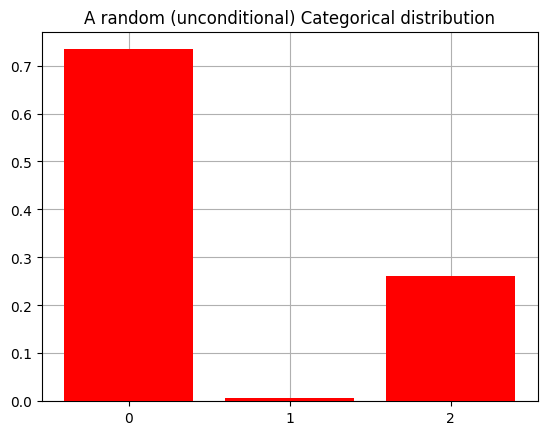

In [7]:
plot_beliefs(my_categorical, title_str = "A random (unconditional) Categorical distribution")

Now let's move onto _conditional_ categorical distributions or likelihoods, i.e. how we represent the distribution of one discrete random variable X, conditioned on the settings of another discrete random variable Y.

We would write these mathematically as:


$$ \begin{align}
P(X | Y)
\end{align}
$$

And can represent them using 2-D `numpy.ndarrays` i.e. matrices

In [8]:
# initialize it with random numbers
p_x_given_y = np.random.rand(3, 4)
print(p_x_given_y.round(3))

[[0.84  0.447 0.938 0.137]
 [0.566 0.028 0.945 0.489]
 [0.534 0.473 0.429 0.883]]


In [9]:
# normalize it
p_x_given_y = utils.norm_dist(p_x_given_y)
print(p_x_given_y.round(3))

[[0.433 0.472 0.406 0.091]
 [0.292 0.029 0.409 0.324]
 [0.275 0.499 0.186 0.585]]


Now print the first column (i.e. $P(X | Y = 0)$) and show that it's a proper categorical distribution

In [10]:
print(p_x_given_y[:,0].reshape(-1,1))
print(f'Integral of P(X|Y=0): {p_x_given_y[:,0].sum()}')

[[0.43293315]
 [0.29181294]
 [0.27525391]]
Integral of P(X|Y=0): 1.0


In [11]:
p_x_given_y[0,:].sum()

1.4008029088061198

So column `i` of the matrix `p_x_given_y` represents the conditional probability of $X$, given the `i`-th level of the random variable $Y$, i.e. $P(X | Y = i)$

Next: taking expectations of random variables using matrix-vector products

In [12]:
""" Create a P(Y) and P(X|Y) using the same numbers from the slides """

p_y = np.array([0.75, 0.25]) # this is already normalized - you don't need to `utils.norm_dist()` it!

# the columns here are already normalized - you don't need to `utils.norm_dist()` it!
p_x_given_y = np.array([[0.6, 0.5],
                        [0.15, 0.41], 
                        [0.25, 0.09]])

print(p_y.round(3).reshape(-1,1))
print(p_x_given_y.round(3))

[[0.75]
 [0.25]]
[[0.6  0.5 ]
 [0.15 0.41]
 [0.25 0.09]]


Calculate expected value of $X$, given our current _belief_ about $Y$, i.e. $P(Y)$ using a simple matrix-vector product, of the form $\mathbf{A}\mathbf{x}$.

In [13]:
""" Calculate the expectation using numpy's dot product functionality """

# first version of the dot product (using the method of a numpy array)
E_x_wrt_y = p_x_given_y.dot(p_y)

# second version of the dot product (using the function np.dot with two arguments)
# E_x_wrt_y = np.dot(p_x_given_y, p_y)

Now print it and verify the result is a proper categorical distribution (integrates to 1.0)

In [14]:
print(E_x_wrt_y)
print(f'Integral: {E_x_wrt_y.sum().round(3)}')

[0.575 0.215 0.21 ]
Integral: 1.0


## **A simple environment: Grid-world**
Now that we understand categorical distributions and how to take conditional expectations of random variables, with categorical conditional and prior distributions, let's move onto a worked example of Active Inference, so-called 'Grid-World'. 

Before we write down the generative model $P(o,s)$ of an active inference agent who will navigate Grid-World, let's start by establishing what exactly this environment is and how we're going to represent it mathematically.

In [15]:
import itertools

""" Create  the grid locations in the form of a list of (Y, X) tuples -- HINT: use itertools """
grid_locations = list(itertools.product(range(3), repeat = 2))
print(grid_locations)

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]


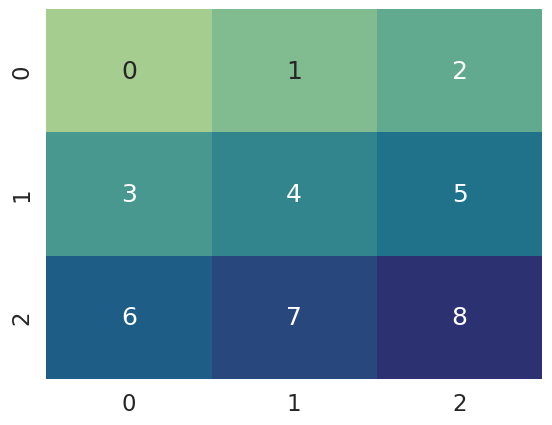

In [16]:
plot_grid(grid_locations)

## **Building the generative model**: $\mathbf{A}$, $\mathbf{B}$, $\mathbf{C}$, and $\mathbf{D}$

### 1. The **A** matrix or $P(o\mid s)$. 

---

The generative model's "prior beliefs" about how hidden states relate to observations

In [17]:
""" Create variables for the storing the dimensionalities of the hidden states and the observations """

n_states = len(grid_locations)
n_observations = len(grid_locations)

print(f'Dimensionality of hidden states: {n_states}')
print(f'Dimensionality of observations: {n_observations}')

Dimensionality of hidden states: 9
Dimensionality of observations: 9


In [18]:
""" Create the A matrix  """

A = np.zeros( (n_states, n_observations) )

In [19]:
""" Create an umambiguous or 'noise-less' mapping between hidden states and observations """

np.fill_diagonal(A, 1.0)

# alternative:
# A = np.eye(n_observations, n_states)

Likelihood matrices show relationships between indices of the state space, which are indexed linearly. Remember the (Y, X) coordinates of the grid world don't necessarily neatly map onto to the locations in the matrix here, which has 'unwrapped' the Grid World's (Y, X) locations into columns/rows.

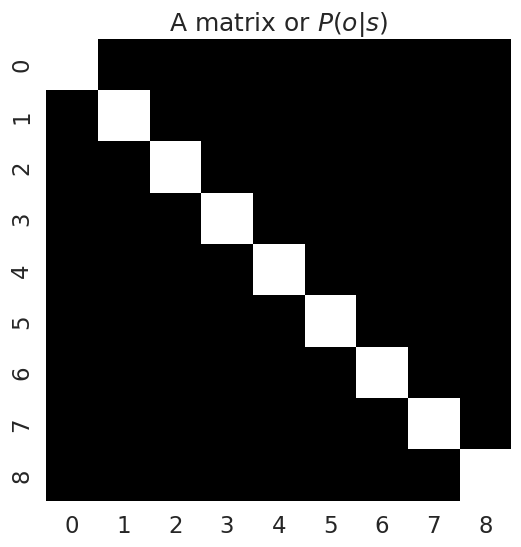

In [20]:
plot_likelihood(A, title_str = "A matrix or $P(o|s)$")

How could we introduce uncertainty into this A matrix? I.e. how do we introduce ambiguity or uncertainty into the agent's model of the world? 

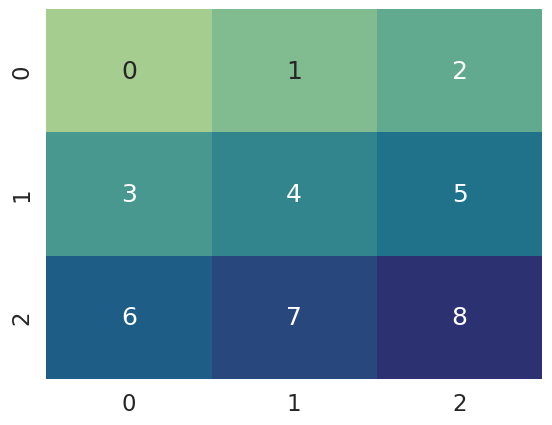

In [21]:
""" Remind yourself of the mapping between linear indices (0 through 8) and grid locations (Y, X) """
plot_grid(grid_locations)

In [22]:
A_noisy = A.copy()

# this line says: the probability of seeing yourself in location 0, given you're in location 0, is 1/3, AKA P(o == 0 | s == 0) = 0.3333....
A_noisy[0,0] = 1 / 3.0 # corresponds to location (0,0)

# this line says: the probability of seeing yourself in location 1, given you're in location 0, is 1/3, AKA P(o == 1 | s == 0) = 0.3333....
A_noisy[1,0] = 1 / 3.0 # corresponds to one step to the right from (0, 1)

# this line says: the probability of seeing yourself in location 3, given you're in location 0, is 1/3, AKA P(o == 3 | s == 0) = 0.3333....
A_noisy[3,0] = 1 / 3.0 # corresponds to one step down from (1, 0)

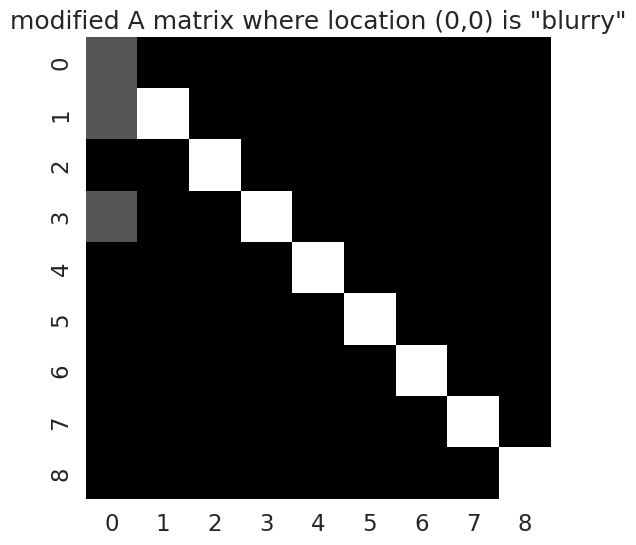

In [23]:
plot_likelihood(A_noisy, title_str = 'modified A matrix where location (0,0) is "blurry"')

In [24]:
""" Let's make ake one grid location "ambiguous" in the sense that it could be easily confused with neighbouring locations """
my_A_noisy = A_noisy.copy()

# locations 3 and 7 are the nearest neighbours to location 6
my_A_noisy[3,6] = 1.0 / 3.0
my_A_noisy[6,6] = 1.0 / 3.0
my_A_noisy[7,6] = 1.0 / 3.0

# Alternatively: you could have the probability spread among locations 3, 4, 6, and 7. This is basically saying, that whole lower-left corner of grid-world is blurry, if you're in location 6
# Remember to make sure the A matrix is column normalized. So if you do it this way, with the probabilities spread among 4 perceived locations, then you'll have to make sure the probabilities sum to 1.0
# my_A_noisy[3,6] = 1.0 / 4.0
# my_A_noisy[4,6] = 1.0 / 4.0
# my_A_noisy[6,6] = 1.0 / 4.0
# my_A_noisy[7,6] = 1.0 / 4.0

Now plot the new A matrix, that now has two "blurry" locations

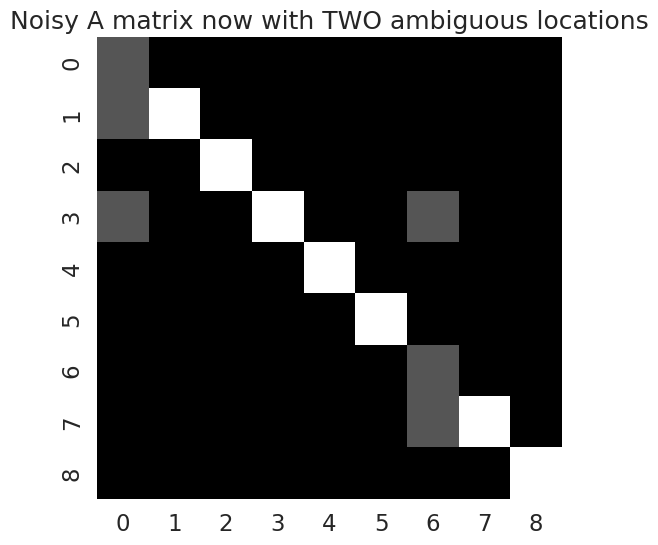

In [25]:
plot_likelihood(my_A_noisy, title_str = "Noisy A matrix now with TWO ambiguous locations")

### 2. The **B** matrix or $P(s_{t}\mid s_{t-1}, u_{t-1})$.


---

The generative model's "prior beliefs" about (controllable) transitions between hidden states over time. Namely, how do hidden states at time $t$ result from hidden states at some previous time $t-1$. These transition dynamics are further conditioned on some past action $u_t$.

In [26]:
actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

def create_B_matrix():
  B = np.zeros( (len(grid_locations), len(grid_locations), len(actions)) )

  for action_id, action_label in enumerate(actions):

    for curr_state, grid_location in enumerate(grid_locations):

      y, x = grid_location

      if action_label == "UP":
        next_y = y - 1 if y > 0 else y 
        next_x = x
      elif action_label == "DOWN":
        next_y = y + 1 if y < 2 else y 
        next_x = x
      elif action_label == "LEFT":
        next_x = x - 1 if x > 0 else x 
        next_y = y
      elif action_label == "RIGHT":
        next_x = x + 1 if x < 2 else x 
        next_y = y
      elif action_label == "STAY":
        next_x = x
        next_y = y
      new_location = (next_y, next_x)
      next_state = grid_locations.index(new_location)
      B[next_state, curr_state, action_id] = 1.0
  return B

B = create_B_matrix()

Let's now explore what it looks to "take" an action, using matrix-vector product of an action-conditioned "slice" of the $\mathbf{B}$ array and a previous state vector

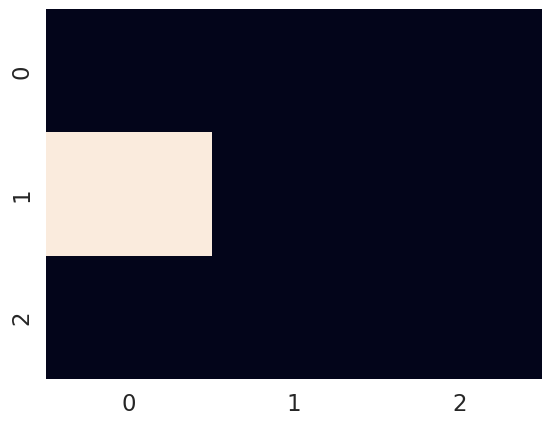

In [27]:
""" Define a starting location""" 
starting_location = (1,0)

"""get the linear index of the state"""
state_index = grid_locations.index(starting_location)

"""  and create a state vector out of it """
starting_state = utils.onehot(state_index, n_states)

plot_point_on_grid(starting_state, grid_locations)

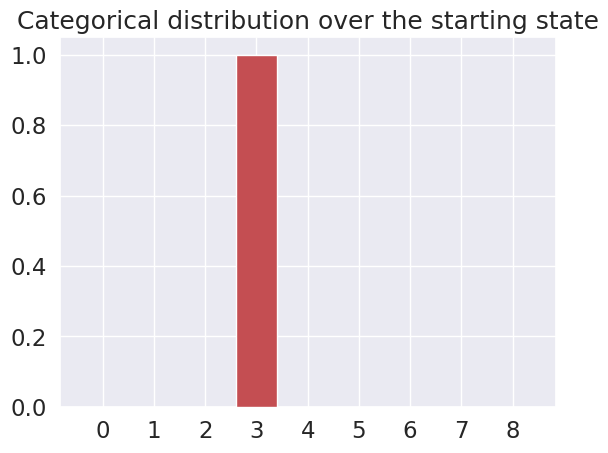

In [28]:
plot_beliefs(starting_state, "Categorical distribution over the starting state")

Now let's imagine we're moving **"RIGHT"** - write the conditional expectation, that will create the state vector corresponding to the new state after taking a step to the right.

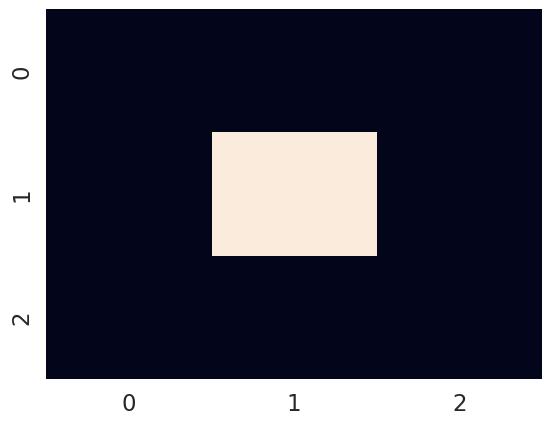

In [29]:
""" Redefine the action here, just for reference """
actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

""" Generate the next state vector, given the starting state and the B matrix"""
right_action_idx = actions.index("RIGHT") 
next_state = B[:,:, right_action_idx].dot(starting_state) # input the indices to the B matrix

""" Plot the next state, after taking the action """
plot_point_on_grid(next_state, grid_locations)

Now let's imagine we're moving **"DOWN"** from where we just landed - write the conditional expectation, that will create the state vector corresponding to the new state after taking a step down.

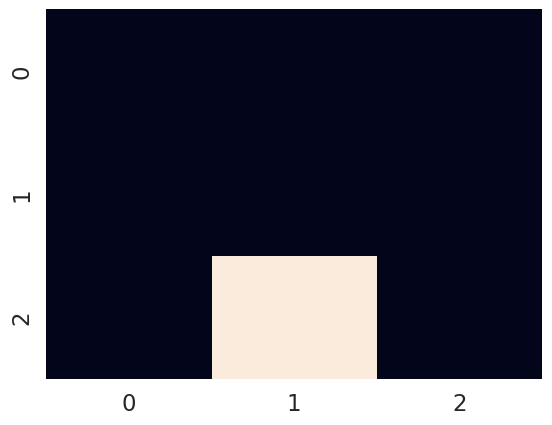

In [30]:
""" Generate the next state vector, given the previous state and the B matrix"""
prev_state = next_state.copy()
down_action_index = actions.index("DOWN")
next_state = B[:,:,down_action_index].dot(prev_state)

"""  Plot the new state vector, after making the movement """
plot_point_on_grid(next_state, grid_locations)

### 3. The prior over observations: the $\mathbf{C}$ vector or $\tilde{P}(o)$

---

The (biased) generative model's prior preference for particular observations, encoded in terms of probabilities.


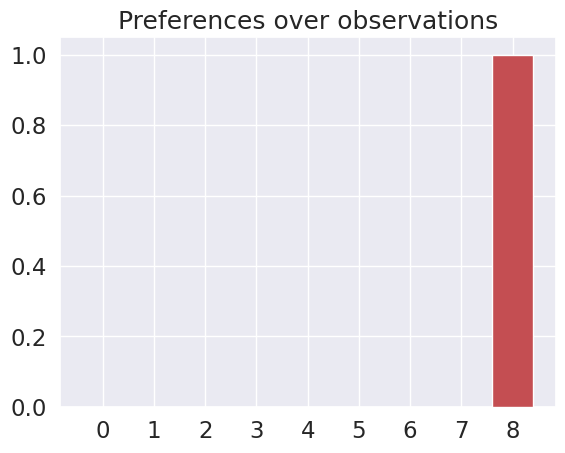

In [31]:
""" Create an empty vector to store the preferences over observations """
C = np.zeros(n_observations)

""" Choose an observation index to be the 'desired' rewarding index, and fill out the C vector accordingly """
desired_location = (2,2) # choose a desired location
desired_location_index = grid_locations.index(desired_location) # get the linear index of the grid location, in terms of 0 through 8

C[desired_location_index] = 1.0 # set the preference for that location to be 100%, i.e. 1.0

"""  Let's look at the prior preference distribution """
plot_beliefs(C, title_str = "Preferences over observations")

### 3. The prior over hidden states: the $\mathbf{D}$ vector or $P(s)$

---

The generative model's prior belief over hidden states at the first timestep.


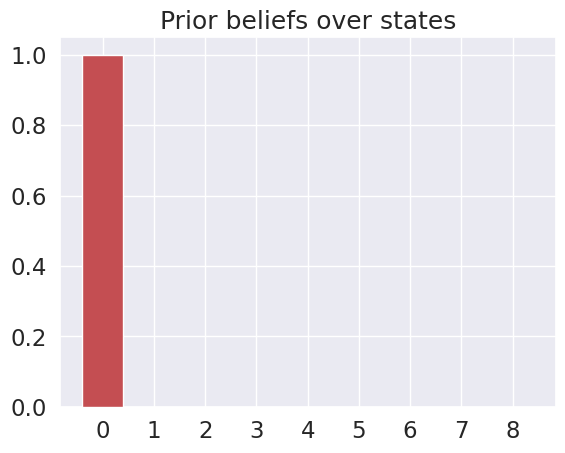

In [32]:
""" Create a D vector, basically a belief that the agent has about its own starting location """

# create a one-hot / certain belief about initial state
D = utils.onehot(0, n_states)

# demonstrate hwo belief about initial state can also be uncertain / spread among different possible initial states
# alternative, where you have a degenerate/noisy prior belief
# D = utils.norm_dist(np.ones(n_states))

""" Let's look at the prior over hidden states """
plot_beliefs(D, title_str = "Prior beliefs over states")

## **Hidden state inference**

Hidden state inference proceeds by finding the setting of the optimal variational posterior $q(s_t)$ that minimizes the variational free energy. For the simple POMDP generative model and posterior we're considering here, this update reduces to a remarkably simple update rule, that is essentially proportional to Bayes` rule:

$$
\begin{align}
q(s_t) = \sigma\left(\ln \mathbf{A}[o,:] + \ln\mathbf{B}[:,:,u] \cdot q(s_{t-1})\right) 
\end{align}
$$


Import the `softmax` function and a numerically-stable version of `np.log` from `pymdp.maths`

In [33]:
from pymdp.maths import softmax
from pymdp.maths import spm_log_single as log_stable

Below we implement the `infer_states()` function

In [34]:
""" Create an infer states function that implements the math we just discussed"""

def infer_states(observation_index, A, prior):

  """ Implement inference here -- NOTE: prior is already passed in, so you don't need to do anything with the B matrix. """
  """ This function has already been given P(s_t). The conditional expectation that creates "today's prior", using "yesterday's posterior", will happen *before calling* this function"""
  
  log_likelihood = log_stable(A[observation_index,:])

  log_prior = log_stable(prior)

  qs = softmax(log_likelihood + log_prior)
   
  return qs

Let's do a simulated single timestep of hidden state inference

In [35]:
qs_past = utils.onehot(4, n_states) # agent believes they were at location 4 -- i.e. (1,1) one timestep ago

last_action = "UP" # the agent knew it moved "UP" one timestep ago
action_id = actions.index(last_action) # get the action index for moving "UP"

Get "today's prior" using the past posterior and the past action, i.e. calculate:


$$ \begin{align}
P(s_t) = \mathbf{E}_{q(s_{t-1})}\left[P(s_t | s_{t-1}, u_{t-1})\right]
\end{align}
$$

and choose an observation that is consistent with the new location 


In [36]:
prior = B[:,:,action_id].dot(qs_past)

observation_index = 1

Now run the `infer_states()` function, using the observation, the $\mathbf{A}$ matrix, and the prior we just calculated above

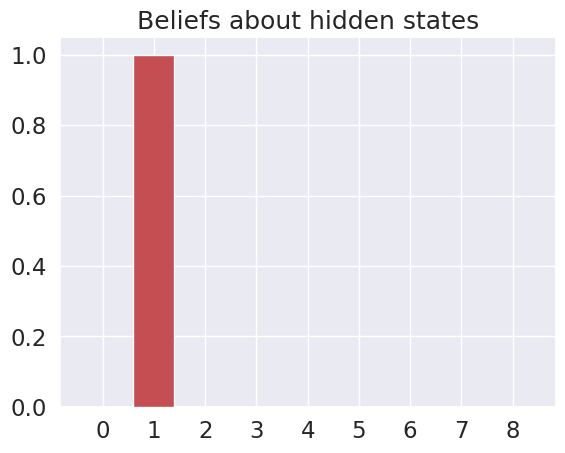

In [37]:
qs_new = infer_states(observation_index, A, prior)
plot_beliefs(qs_new, title_str = "Beliefs about hidden states")

Let's see what happens if observation and the prior "disagree" with eachother?

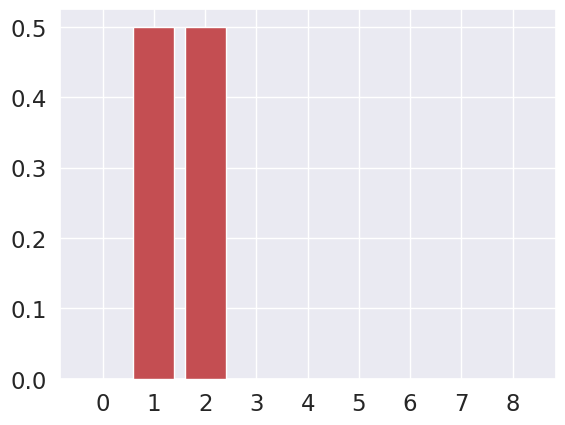

In [38]:
""" Get an observation that 'conflicts' with the prior """
observation_index = 2 # this is like the agent is seeing itself in location (0, 2)
qs_new = infer_states(observation_index, A, prior)
plot_beliefs(qs_new)

What happens if likelihood and prior are partially ambiguous?

In [39]:
""" Create an ambiguous A matrix """
A_partially_ambiguous = softmax(A)
print(A_partially_ambiguous.round(3))

[[0.254 0.093 0.093 0.093 0.093 0.093 0.093 0.093 0.093]
 [0.093 0.254 0.093 0.093 0.093 0.093 0.093 0.093 0.093]
 [0.093 0.093 0.254 0.093 0.093 0.093 0.093 0.093 0.093]
 [0.093 0.093 0.093 0.254 0.093 0.093 0.093 0.093 0.093]
 [0.093 0.093 0.093 0.093 0.254 0.093 0.093 0.093 0.093]
 [0.093 0.093 0.093 0.093 0.093 0.254 0.093 0.093 0.093]
 [0.093 0.093 0.093 0.093 0.093 0.093 0.254 0.093 0.093]
 [0.093 0.093 0.093 0.093 0.093 0.093 0.093 0.254 0.093]
 [0.093 0.093 0.093 0.093 0.093 0.093 0.093 0.093 0.254]]


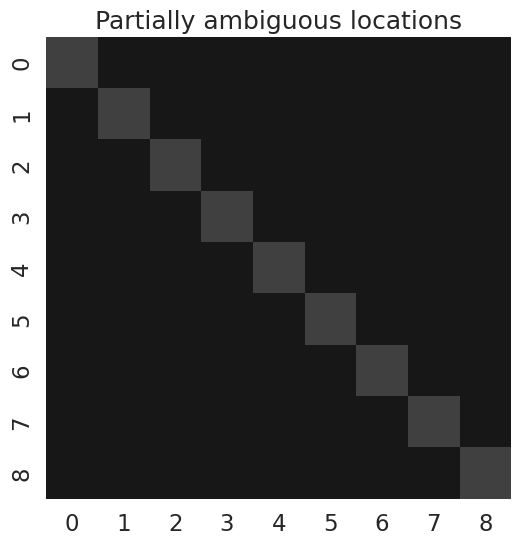

In [40]:
plot_likelihood(A_partially_ambiguous, title_str = "Partially ambiguous locations")

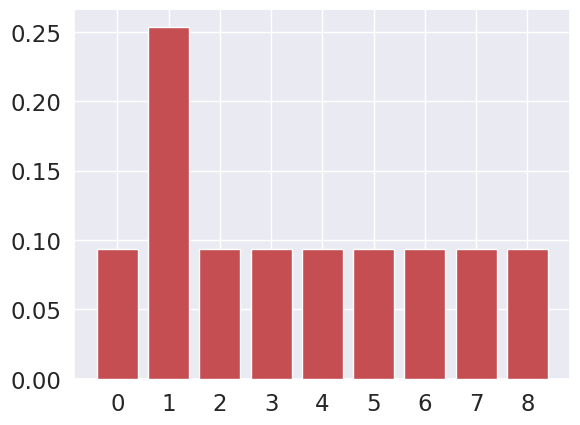

In [41]:
""" ... and a noisy prior """
noisy_prior = softmax(prior) 
plot_beliefs(noisy_prior)

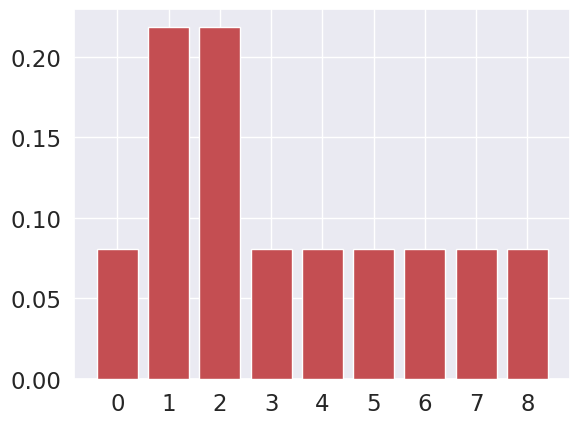

In [42]:
""" Do inference with the new, partially-ambiguous A matrix and the noised-up prior """
qs_new = infer_states(observation_index, A_partially_ambiguous, noisy_prior)
plot_beliefs(qs_new)

## **Action Selection and the Expected Free Energy** 

Now we'll write functions to compute the expected states $Q(s_{t+1}|u_t)$, expected observations $Q(o_{t+1}|u_t)$, the entropy of $P(o|s)$: $\mathbf{H}\left[\mathbf{A}\right]$, and the KL divergence between the expected observations and the prior preferences $\mathbf{C}$.

In [43]:
""" define component functions for computing expected free energy """

def get_expected_states(B, qs_current, action):
  """ Compute the expected states one step into the future, given a particular action """
  qs_u = B[:,:,action].dot(qs_current)

  return qs_u

def get_expected_observations(A, qs_u):
  """ Compute the expected observations one step into the future, given a particular action """

  qo_u = A.dot(qs_u)

  return qo_u

def entropy(A):
  """ Compute the entropy of a set of conditional distributions, i.e. one entropy value per column """

  H_A = - (A * log_stable(A)).sum(axis=0)

  return H_A

def kl_divergence(qo_u, C):
  """ Compute the Kullback-Leibler divergence between two 1-D categorical distributions"""
  
  return (log_stable(qo_u) - log_stable(C)).dot(qo_u)

Now let's imagine we're in some starting state, like (1,1)
N.B. This is the generative process we're talking about -- i.e. the true state of the world

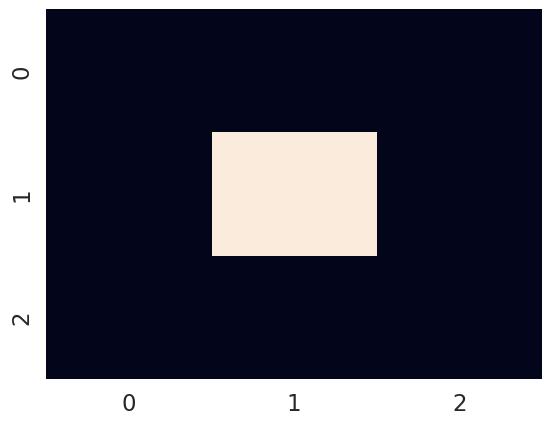

In [44]:
""" Get state index, create state vector for (1,1) """

state_idx = grid_locations.index((1,1))
state_vector = utils.onehot(state_idx, n_states)
plot_point_on_grid(state_vector, grid_locations)

And let's furthermore assume we start with the (accurate) belief about our location, that we are in location (1,1). So let's just make our current $Q(s_t)$ equal to the true state vector. You could think of this as if we just did one 'step' of inference using our current observation along with precise `A`/`B` matrices.

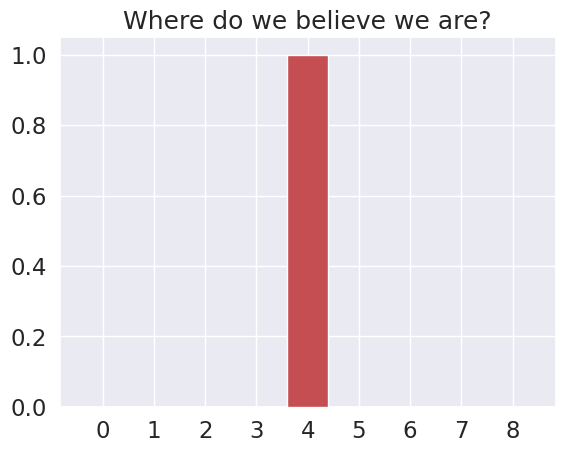

In [45]:
""" Make qs_current identical to the true starting state """ 
qs_current = state_vector.copy()
plot_beliefs(qs_current, title_str ="Where do we believe we are?")

And we prefer to be in state (1,2). So we express that as high probability over the corresponding entry of the $\mathbf{C}$ vector -- that happens to be index 5.

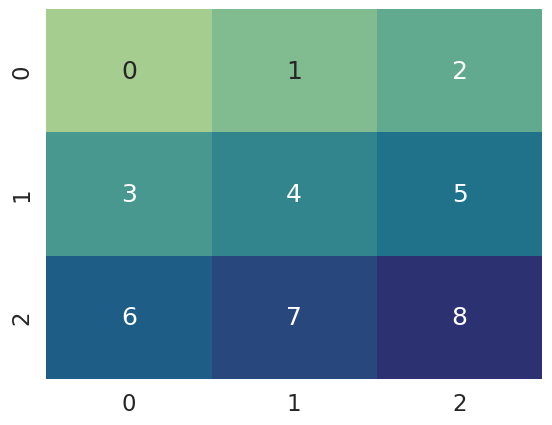

In [46]:
plot_grid(grid_locations)

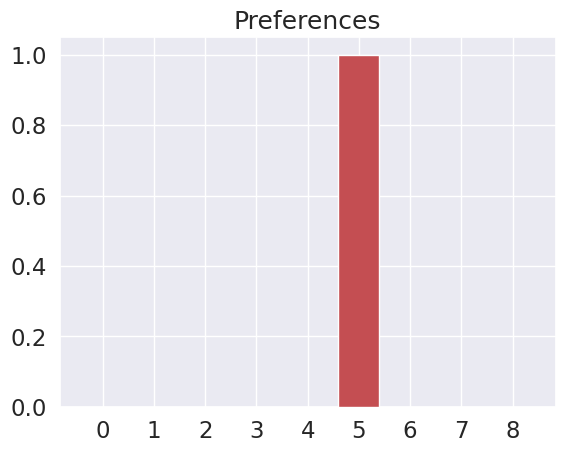

In [47]:
""" Create a preference to be in (1,2) """

desired_idx = grid_locations.index((1,2))

C = utils.onehot(desired_idx, n_observations)

plot_beliefs(C, title_str = "Preferences")

Now to keep things simple, let's evaluate the expected free energies $\mathbf{G}$ of just two actions that we could take from our current position -- either moving LEFT or moving RIGHT. Let's remind ourselves of what action indices those are

In [48]:
left_idx = actions.index("LEFT")
right_idx = actions.index("RIGHT")

print(f'Action index of moving left: {left_idx}')
print(f'Action index of moving right: {right_idx}')

Action index of moving left: 2
Action index of moving right: 3


And now let's use the functions we've just defined, in combination with our `A`, `B`, `C` arrays and our current posterior `qs_current`, to compute the expected free energies for the two actions

In [49]:
""" Compute the expected free energies for moving left vs. moving right """
G = np.zeros(2) # store the expected free energies for each action in here

"""
Compute G for MOVE LEFT here 
"""

qs_u_left = get_expected_states(B, qs_current, left_idx)
# alternative
# qs_u_left = B[:,:,left_idx].dot(qs_current)

H_A = entropy(A)
qo_u_left = get_expected_observations(A, qs_u_left)
# alternative
# qo_u_left = A.dot(qs_u_left)

predicted_uncertainty_left = H_A.dot(qs_u_left)
predicted_divergence_left = kl_divergence(qo_u_left, C)
G[0] = predicted_uncertainty_left + predicted_divergence_left

"""
Compute G for MOVE RIGHT here 
"""

qs_u_right = get_expected_states(B, qs_current, right_idx)
# alternative
# qs_u_right = B[:,:,right_idx].dot(qs_current)

H_A = entropy(A)
qo_u_right = get_expected_observations(A, qs_u_right)
# alternative
# qo_u_right = A.dot(qs_u_right)

predicted_uncertainty_right = H_A.dot(qs_u_right)
predicted_divergence_right = kl_divergence(qo_u_right, C)
G[1] = predicted_uncertainty_right + predicted_divergence_right



""" Now let's print the expected free energies for the two actions, that we just calculated """
print(f'Expected free energy of moving left: {G[0]}\n')
print(f'Expected free energy of moving right: {G[1]}\n')

Expected free energy of moving left: 36.841361487904734

Expected free energy of moving right: 0.0



Now let's use formula for the posterior over actions, i.e. 


$$ \begin{align}
Q(u_t) = \sigma(-\mathbf{G})
\end{align} $$

to compute the probabilities of each action

In [50]:
Q_u = softmax(-G)

""" and print the probability of each action """
print(f'Probability of moving left: {Q_u[0]}')
print(f'Probability of moving right: {Q_u[1]}')

Probability of moving left: 9.999999999999965e-17
Probability of moving right: 1.0


For usefulness later on, let's wrap the expected free energy calculations into a function

In [51]:
def calculate_G(A, B, C, qs_current, actions):

  G = np.zeros(len(actions)) # vector of expected free energies, one per action

  H_A = entropy(A) # entropy of the observation model, P(o|s)

  for action_i in range(len(actions)):
    
    qs_u = get_expected_states(B, qs_current, action_i) # expected states, under the action we're currently looping over
    qo_u = get_expected_observations(A, qs_u)           # expected observations, under the action we're currently looping over

    pred_uncertainty = H_A.dot(qs_u) # predicted uncertainty, i.e. expected entropy of the A matrix
    pred_div = kl_divergence(qo_u, C) # predicted divergence

    G[action_i] = pred_uncertainty + pred_div # sum them together to get expected free energy
  
  return G

## **Complete Recipe for Active Inference**

1.   Sample an observation $o_t$ from the current state of the environment
2.   Perform inference over hidden states i.e., optimize $q(s)$ through free-energy minimization
3. Calculate expected free energy of actions $\mathbf{G}$ 
4. Sample action from the posterior over actions $Q(u_t) \sim \sigma(-\mathbf{G})$.
5. Use the sampled action $a_t$ to perturb the generative process and go back to step 1.


---

Let's start by creating a class that will represent the Grid World environment (i.e., _generative process_) that our active inference agent will navigate within. Note that we don't need to specify the generative process in terms of `A` and `B` matrices - the generative process will be as arbitrary and complex as the environment is. The `A` and `B` matrices are just the agent's _representation_ of the world and the task, which in this case happen to capture the Markovian, noiseless dynamics of the world perfectly.


In [52]:
class GridWorldEnv():
    
    def __init__(self,starting_state = (0,0)):

        self.init_state = starting_state
        self.current_state = self.init_state
        print(f'Starting state is {starting_state}')
    
    def step(self,action_label):

        (Y, X) = self.current_state

        if action_label == "UP": 
          
          Y_new = Y - 1 if Y > 0 else Y
          X_new = X

        elif action_label == "DOWN": 

          Y_new = Y + 1 if Y < 2 else Y
          X_new = X

        elif action_label == "LEFT": 
          Y_new = Y
          X_new = X - 1 if X > 0 else X

        elif action_label == "RIGHT": 
          Y_new = Y
          X_new = X +1 if X < 2 else X

        elif action_label == "STAY":
          Y_new, X_new = Y, X 
        
        self.current_state = (Y_new, X_new) # store the new grid location

        obs = self.current_state # agent always directly observes the grid location they're in 

        return obs

    def reset(self):
        self.current_state = self.init_state
        print(f'Re-initialized location to {self.init_state}')
        obs = self.current_state
        print(f'..and sampled observation {obs}')

        return obs
    
env = GridWorldEnv()

Starting state is (0, 0)


Now equipped with an environment and a generative model (our `A`, `B`, `C`, and `D`), we can code up the entire active inference loop

---

To have everything in one place, let's re-create the whole generative model


In [53]:
""" Fill out the components of the generative model """

A = np.eye(n_observations, n_states)

B = create_B_matrix()

C = utils.onehot(grid_locations.index( (2, 2) ), n_observations) # make the agent prefer location (2,2) (lower right corner of grid world)

D = utils.onehot(grid_locations.index( (1,2) ), n_states) # start the agent with the prior belief that it starts in location (1,2) 

actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

Now let's initialize the environment with starting state `(1,2)`, so that the agent has accurate beliefs about where it's starting.

In [54]:
env = GridWorldEnv(starting_state = (1,2))

Starting state is (1, 2)


Let's write a function that runs the whole active inference loop, and then run it for `T = 5` timesteps.

In [ ]:
""" Write a function that, when called, runs the entire active inference loop for a desired number of timesteps"""

def run_active_inference_loop(A, B, C, D, actions, env, T = 5):

  """ Initialize the prior that will be passed in during inference to be the same as `D` """
  prior = D.copy() # initial prior should be the D vector

  """ Initialize the observation that will be passed in during inference - hint use env.reset()"""
  obs = env.reset() # initialize the `obs` variable to be the first observation you sample from the environment, before `step`-ing it.

  for t in range(T):

    print(f'Time {t}: Agent observes itself in location: {obs}')

    # convert the observation into the agent's observational state space (in terms of 0 through 8)
    obs_idx = grid_locations.index(obs)

    # perform inference over hidden states
    qs_current = infer_states(obs_idx, A, prior)

    plot_beliefs(qs_current, title_str = f"Beliefs about location at time {t}")

    # calculate expected free energy of actions
    G = calculate_G(A, B, C, qs_current, actions)
    
    # compute action posterior
    Q_u = softmax(-G)

    # sample action from probability distribution over actions
    chosen_action = utils.sample(Q_u)

    # compute prior for next timestep of inference
    prior = B[:,:,chosen_action].dot(qs_current) 

    # update generative process
    action_label = actions[chosen_action]

    obs = env.step(action_label)
  
  return qs_current

""" Run the function we just wrote, for T = 5 timesteps """
qs = run_active_inference_loop(A, B, C, D, actions, env, T = 5)


## **Planning**

But there's a problem. Imagine we started the agent at the top left corner (coordinate `(0,0)`) rather than one step away from the target location

In [ ]:
D = utils.onehot(grid_locations.index((0,0)), n_states) # let's have the agent believe it starts in location (0,0)

env = GridWorldEnv(starting_state = (0,0))
qs = run_active_inference_loop(A, B, C, D, actions, env, T = 5)

Because the expected free energy of each action is only evaluated for one timestep in the future, the agent has no way of knowing which action to initially take, to get closer to its final "goal" of `(2,2)`. This is because the expected divergence term for all actions $\operatorname{D}_{KL}(Q(o|u) \parallel \mathbf{C})$ is identical for all considered actions (which are just 1-step moves away from starting from `(0,0)` ). This speaks to the importance of planning, or _multiple timestep policies_. 


Now let's do active inference with multi-step policies

We can rely on a useful function from `pymdp`'s `control` module called `construct_policies()` to automatically generate a list of all the policies we want to entertain, for a given number of control states (actions) and a desired temporal horizon. 

In [57]:
from pymdp.control import construct_policies

In [58]:
policy_len = 4
n_actions = len(actions)

# we have to wrap `n_states` and `n_actions` in a list for reasons that will become clear in Part II
all_policies = construct_policies([n_states], [n_actions], policy_len = policy_len)

print(f'Total number of policies for {n_actions} possible actions and a planning horizon of {policy_len}: {len(all_policies)}')

Total number of policies for 5 possible actions and a planning horizon of 4: 625


Let's re-write our expected free energy function, but now we loop over policies (sequences of actions), rather than actions (1-step policies)

In [59]:
def calculate_G_policies(A, B, C, qs_current, policies):

  G = np.zeros(len(policies)) # initialize the vector of expected free energies, one per policy
  H_A = entropy(A)            # can calculate the entropy of the A matrix beforehand, since it'll be the same for all policies

  for policy_id, policy in enumerate(policies): # loop over policies - policy_id will be the linear index of the policy (0, 1, 2, ...) and `policy` will be a column vector where `policy[t,0]` indexes the action entailed by that policy at time `t`

    t_horizon = policy.shape[0] # temporal depth of the policy

    G_pi = 0.0 # initialize expected free energy for this policy

    for t in range(t_horizon): # loop over temporal depth of the policy

      action = policy[t,0] # action entailed by this particular policy, at time `t`

      # get the past predictive posterior - which is either your current posterior at the current time (not the policy time) or the predictive posterior entailed by this policy, one timstep ago (in policy time)
      if t == 0:
        qs_prev = qs_current 
      else:
        qs_prev = qs_pi_t
        
      qs_pi_t = get_expected_states(B, qs_prev, action) # expected states, under the action entailed by the policy at this particular time
      qo_pi_t = get_expected_observations(A, qs_pi_t)   # expected observations, under the action entailed by the policy at this particular time

      kld = kl_divergence(qo_pi_t, C) # Kullback-Leibler divergence between expected observations and the prior preferences C

      G_pi_t = H_A.dot(qs_pi_t) + kld # predicted uncertainty + predicted divergence, for this policy & timepoint

      G_pi += G_pi_t # accumulate the expected free energy for each timepoint into the overall EFE for the policy

    G[policy_id] += G_pi
  
  return G


Let's write a function for computing the action posterior, given the posterior probability of each policy:

In [60]:
def compute_prob_actions(actions, policies, Q_pi):
  P_u = np.zeros(len(actions)) # initialize the vector of probabilities of each action

  for policy_id, policy in enumerate(policies):
    P_u[int(policy[0,0])] += Q_pi[policy_id] # get the marginal probability for the given action, entailed by this policy at the first timestep
  
  P_u = utils.norm_dist(P_u) # normalize the action probabilities
  
  return P_u

Now we can write a new active inference function, that uses temporally-deep planning

In [61]:
def active_inference_with_planning(A, B, C, D, n_actions, env, policy_len = 2, T = 5):

  """ Initialize prior, first observation, and policies """
  
  prior = D # initial prior should be the D vector

  obs = env.reset() # get the initial observation

  policies = construct_policies([n_states], [n_actions], policy_len = policy_len)

  for t in range(T):

    print(f'Time {t}: Agent observes itself in location: {obs}')

    # convert the observation into the agent's observational state space (in terms of 0 through 8)
    obs_idx = grid_locations.index(obs)

    # perform inference over hidden states
    qs_current = infer_states(obs_idx, A, prior)
    plot_beliefs(qs_current, title_str = f"Beliefs about location at time {t}")

    # calculate expected free energy of actions
    G = calculate_G_policies(A, B, C, qs_current, policies)

    # to get action posterior, we marginalize P(u|pi) with the probabilities of each policy Q(pi), given by \sigma(-G)
    Q_pi = softmax(-G)

    # compute the probability of each action
    P_u = compute_prob_actions(actions, policies, Q_pi)

    # sample action from probability distribution over actions
    chosen_action = utils.sample(P_u)

    # compute prior for next timestep of inference
    prior = B[:,:,chosen_action].dot(qs_current) 

    # step the generative process and get new observation
    action_label = actions[chosen_action]
    obs = env.step(action_label)
  
  return qs_current


Now run it to see if the agent is able to navigate to location `(2,2)`

Starting state is (0, 0)
Re-initialized location to (0, 0)
..and sampled observation (0, 0)
Time 0: Agent observes itself in location: (0, 0)


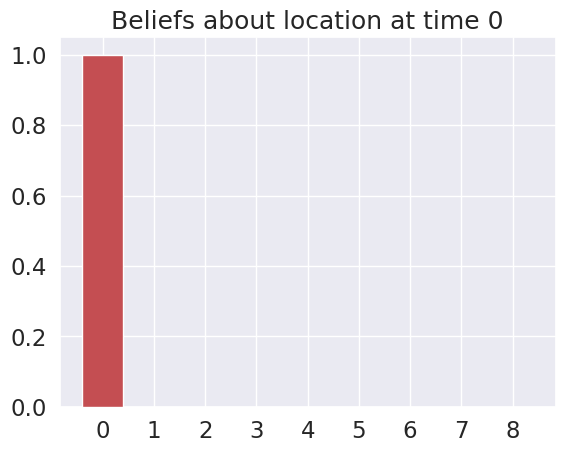

Time 1: Agent observes itself in location: (0, 0)


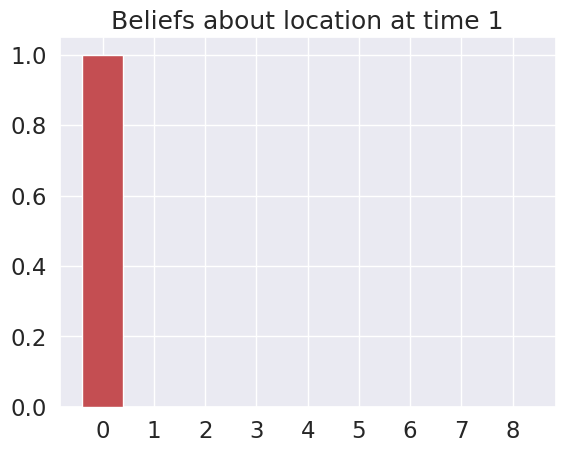

Time 2: Agent observes itself in location: (0, 0)


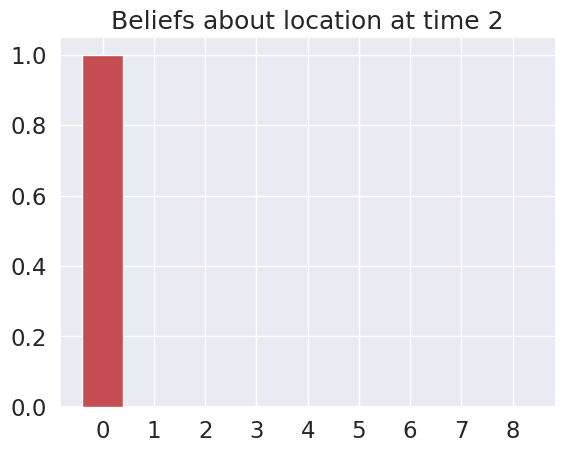

Time 3: Agent observes itself in location: (1, 0)


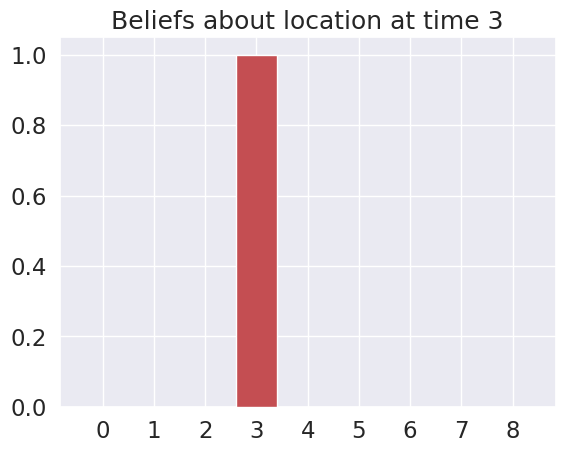

Time 4: Agent observes itself in location: (1, 1)


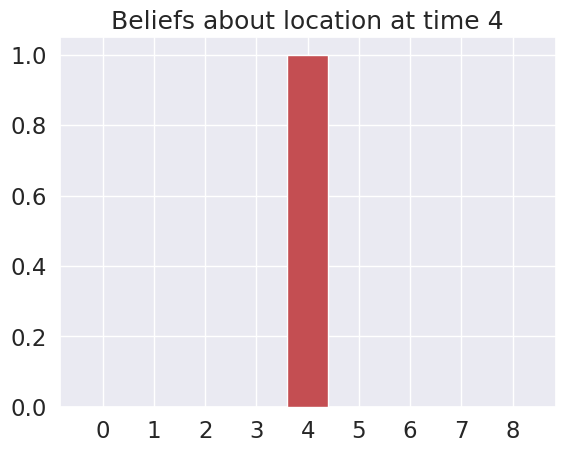

Time 5: Agent observes itself in location: (2, 1)


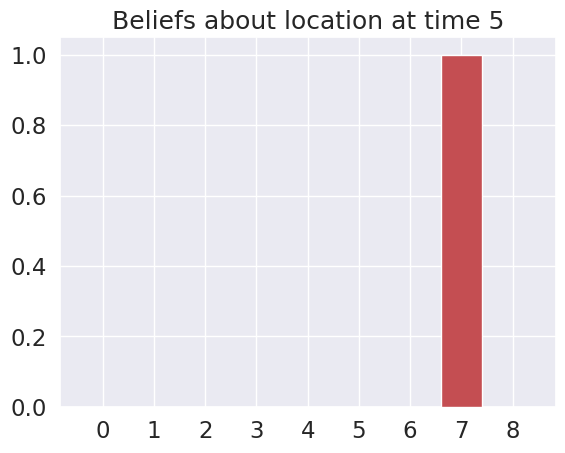

Time 6: Agent observes itself in location: (2, 2)


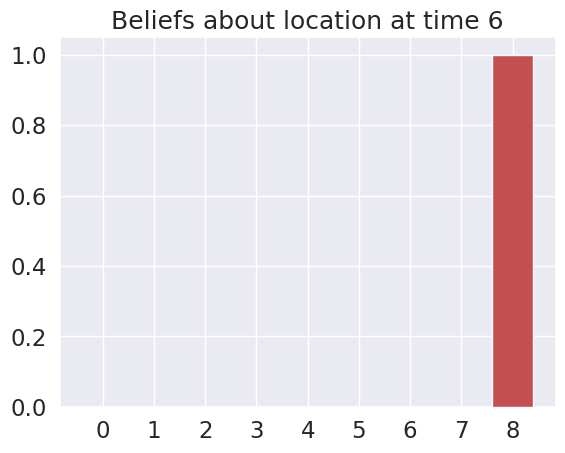

Time 7: Agent observes itself in location: (2, 2)


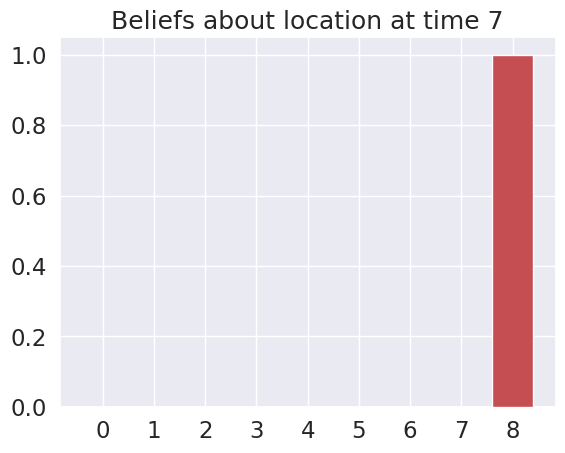

Time 8: Agent observes itself in location: (2, 2)


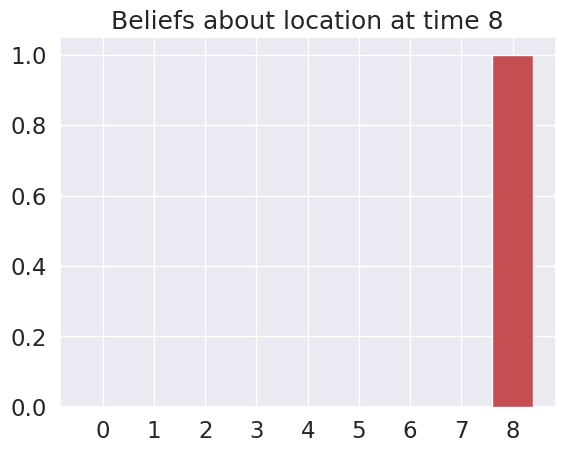

Time 9: Agent observes itself in location: (2, 2)


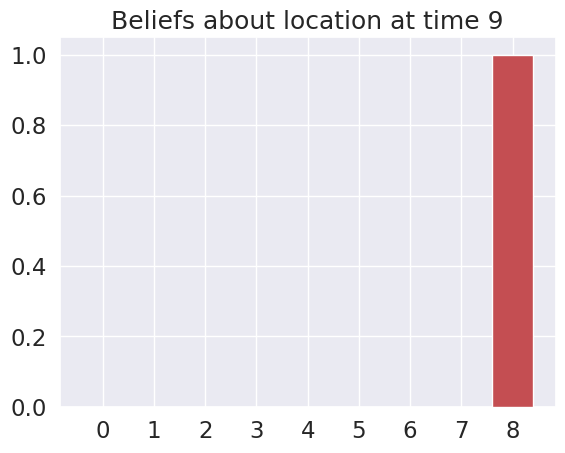

In [62]:
D = utils.onehot(grid_locations.index((0,0)), n_states) # let's have the agent believe it starts in location (0,0) (upper left corner) 
env = GridWorldEnv(starting_state = (0,0))
qs_final = active_inference_with_planning(A, B, C, D, n_actions, env, policy_len = 3, T = 10)